# Part 2: Deploy a model trained using SageMaker distributed data parallel

Use this notebook after you have completed **Part 1: Distributed data parallel MNIST training with PyTorch and SageMaker's distributed data parallel library** in the notebook pytorch_smdataparallel_mnist_demo.ipynb. To deploy the model you previously trained, you need to create a Sagemaker Endpoint. This is a hosted prediction service that you can use to perform inference.

## Finding the model

This notebook uses a stored model if it exists. If you recently ran a training example that use the `%store%` magic, it will be restored in the next cell.

Otherwise, you can pass the URI to the model file (a .tar.gz file) in the `model_data` variable.

To find the location of model files in the [SageMaker console](https://console.aws.amazon.com/sagemaker/home), do the following: 

1. Go to the SageMaker console: https://console.aws.amazon.com/sagemaker/home.
1. Select **Training** in the left navigation pane and then Select **Training jobs**. 
1. Find your recent training job and choose it.
1. In the **Output** section, you should see an S3 URI under **S3 model artifact**. Copy this S3 URI.
1. Uncomment the `model_data` line in the next cell that manually sets the model's URI and replace the placeholder value with that S3 URI.

In [66]:
%store -r model_data
try:
    model_data
except NameError:
    model_data = 's3://sagemaker-sample-files/models/pytorch-smdataparallel-mnist-2021-06-14-23-25-29-876/output/model.tar.gz'
    
print("Using this model: {}".format(model_data))

Using this model: s3://sagemaker-us-west-2-688520471316/pytorch-smdataparallel-mnist-2021-06-14-23-25-29-876/output/model.tar.gz


## Create a model object

You define the model object by using the SageMaker Python SDK's `PyTorchModel` and pass in the model from the `estimator` and the `entry_point`. The endpoint's entry point for inference is defined by `model_fn` as seen in the following code block that prints out `inference.py`. The function loads the model and sets it to use a GPU, if available.

In [48]:
!aws s3 cp s3://sagemaker-sample-files/datasets/image/MNIST/model/pytorch-training-2020-11-21-22-02-56-203/model.tar.gz .

download: s3://sagemaker-sample-files/datasets/image/MNIST/model/pytorch-training-2020-11-21-22-02-56-203/model.tar.gz to ./model.tar.gz


In [49]:
!tar -xvzf model.tar.gz

model.pth


In [50]:
!pygmentize code/inference.py

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements.  See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership.  The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License.  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied.  See the License for the
# specific language governing permissions and limitations
# under the License.

from __future__ import print_function

import os

import torch

# Network definition
from model_def import Net


def model_fn(model_dir):
    print("In model_fn. Model directory is -")
    print(model_dir)
    devi

In [67]:
import sagemaker

role = sagemaker.get_execution_role()

from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(
    model_data=model_data,
    source_dir="code",
    entry_point="inference.py",
    role=role,
    framework_version="1.6.0",
    py_version="py3",
)

### Deploy the model on an endpoint

You create a `predictor` by using the `model.deploy` function. You can optionally change both the instance count and instance type.

In [68]:
predictor = model.deploy(
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge")

-------!

## Test the model
You can test the depolyed model using samples from the test set.


In [54]:
!aws s3 cp s3://sagemaker-sample-files/datasets/image/MNIST/pytorch/ data/ --recursive

download: s3://sagemaker-sample-files/datasets/image/MNIST/pytorch/MNIST/raw/t10k-labels-idx1-ubyte to data/MNIST/raw/t10k-labels-idx1-ubyte
download: s3://sagemaker-sample-files/datasets/image/MNIST/pytorch/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw/t10k-labels-idx1-ubyte.gz
download: s3://sagemaker-sample-files/datasets/image/MNIST/pytorch/MNIST/raw/train-labels-idx1-ubyte to data/MNIST/raw/train-labels-idx1-ubyte
download: s3://sagemaker-sample-files/datasets/image/MNIST/pytorch/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw/train-labels-idx1-ubyte.gz
download: s3://sagemaker-sample-files/datasets/image/MNIST/pytorch/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw/t10k-images-idx3-ubyte.gz
download: s3://sagemaker-sample-files/datasets/image/MNIST/pytorch/MNIST/processed/test.pt to data/MNIST/processed/test.pt
download: s3://sagemaker-sample-files/datasets/image/MNIST/pytorch/MNIST/raw/t10k-images-idx3-ubyte to data/MNIST/raw/t10k-images-idx3-ubyte
download:

Sampled test images: 


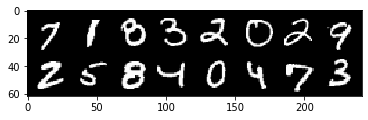

In [69]:
# Download the test set
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


test_set = datasets.MNIST(
    "data",
    download=False,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), 
         transforms.Normalize((0.1307,), (0.3081,))]
    ),
)


# Randomly sample 16 images from the test set
test_loader = DataLoader(test_set, shuffle=True, batch_size=16)
test_images, _ = iter(test_loader).next()

# inspect the images
import torchvision
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def imshow(img):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    return


# unnormalize the test images for displaying
unnorm_images = (test_images * 0.3081) + 0.1307

print("Sampled test images: ")
imshow(torchvision.utils.make_grid(unnorm_images))

In [70]:
import json
x = json.dumps(
    {'inputs': test_images.numpy().tolist()}
)

In [98]:
# invoke endpoint
import boto3
import json

sm_runtime = boto3.client("sagemaker-runtime")

body = json.dumps(
    {'inputs': test_images.numpy().tolist()}
)
content_type = "application/json"

# respnse type
accept = "application/json"

res = sm_runtime.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    Body=body,  # encoded input data
    ContentType=content_type,  # I told the endpoint what's the encode
    Accept=accept,  # I told the endpoint how I want to decode its response
)

# decode the response body
res_body = res["Body"]
pred = res_body.read().decode("utf-8")

print("Type of the response: ", type(pred))
print()
print(pred)
print()

# string -> list
pred = json.loads(pred)

# list -> numpy
pred = np.array(pred, dtype=np.float32)

# predicted class
predicted = np.argmax(pred, axis=1)
print("Predictions: ", predicted)

Type of the response:  <class 'str'>

[[-12.683966636657715, -15.583731651306152, -16.82354736328125, -14.31031608581543, -17.567811965942383, -18.241670608520508, -23.944087982177734, -0.00017474555352237076, -18.168739318847656, -8.67503547668457], [-15.990324974060059, -3.528532761265524e-05, -19.912044525146484, -17.104673385620117, -10.694605827331543, -15.944657325744629, -12.563192367553711, -13.89238452911377, -11.731773376464844, -18.111629486083984], [-0.00022396916756406426, -18.5643367767334, -9.66037368774414, -14.587813377380371, -20.711790084838867, -14.264082908630371, -9.375843048095703, -17.067075729370117, -9.5098295211792, -15.248885154724121], [-14.938820838928223, -11.0601167678833, -10.756078720092773, -0.0003070359816774726, -16.164020538330078, -8.497347831726074, -12.632866859436035, -12.477546691894531, -9.748777389526367, -16.144498825073242], [-36.28738021850586, -21.581363677978516, 0.0, -29.859779357910156, -26.876676559448242, -31.381324768066406, -33.51

## Cleanup

If you don't intend on trying out inference or to do anything else with the endpoint, you should delete it.

In [99]:
predictor.delete_endpoint()